### Imports

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import json


### Methods

In [167]:
def str_to_numpy_array(encoded_str):
    encoded_data = encoded_str.split()
    decoded_data = [int(x) for x in encoded_data]
    decoded_array = np.array(decoded_data)
    return decoded_array

def decode_run_length(encoded_mask, height, width, inverse=False):
    decoded_mask = np.zeros(height * width, dtype=np.uint8) \
        if not inverse else np.ones(height * width, dtype=np.uint8)
    mask_value = 1 if not inverse else 0
    for i in range(0, len(encoded_mask), 2):
        for j in range(0, encoded_mask[i+1]):
            decoded_mask[encoded_mask[i] + j] = mask_value
    decoded_mask = decoded_mask.reshape((height, width))
    return decoded_mask

def get_contour(mask):
    mask_coordinates = np.array(np.where(mask > 0)).T
    i = 0
    contour = []
    while i < len(mask_coordinates):
        step = 0
        contour.append(mask_coordinates[i])
        while i+step < len(mask_coordinates)-1:
            if mask_coordinates[i+step][0] == mask_coordinates[i][0]:
                step += 1
            else:
                break
        if i + step < len(mask_coordinates)-1:
            contour.append(mask_coordinates[i+step-1])
        else:
            contour.append(mask_coordinates[i+step])
            break
        i += step
    return np.array(contour)

In [241]:
def rle_decode(mask_rle, shape, color=1):
    """ TBD

    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return

    Returns:
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color

    # Don't forget to change the image back to the original shape
    return img.reshape(shape)

### Test Example

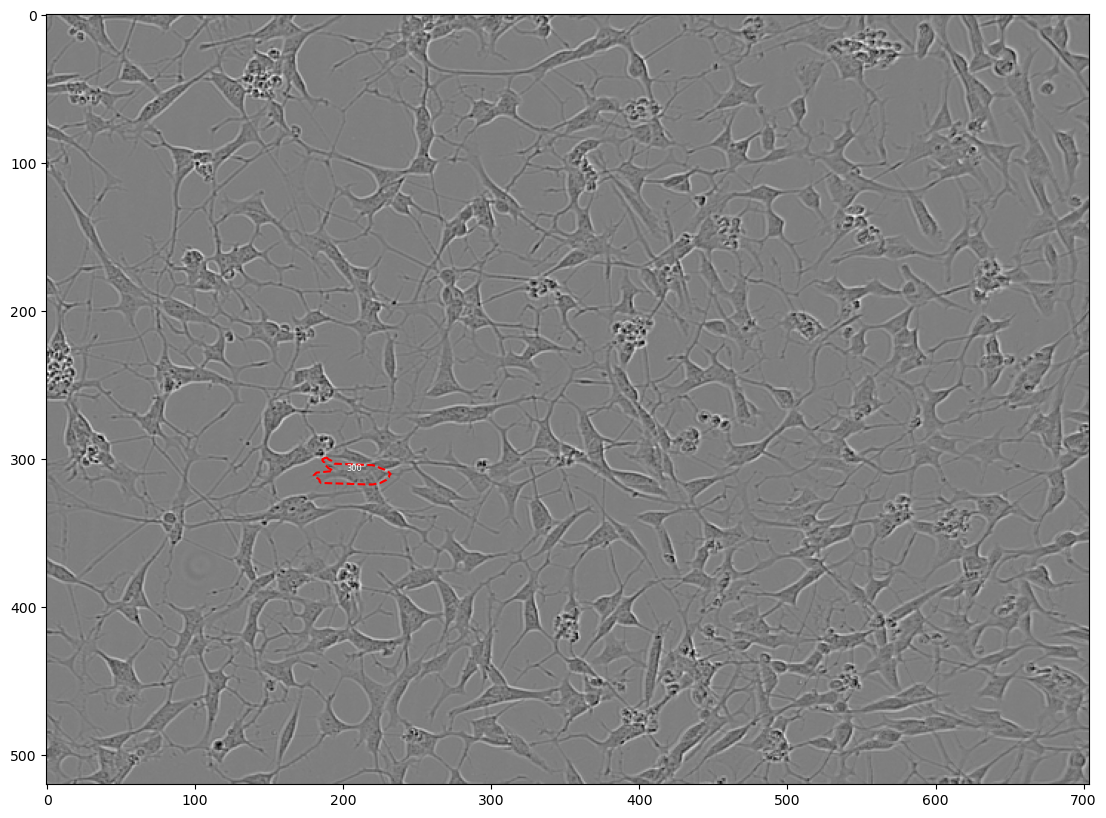

In [249]:
train_path = "./dataset/sartorius-cell-instance-segmentation/train"
train_annotations = "./dataset/sartorius-cell-instance-segmentation/train.csv"
test_path = "./dataset/sartorius-cell-instance-segmentation/test"

df = pd.read_csv(train_annotations)

selected_row_index = 300
selected_row_id = df.loc[selected_row_index, 'id']
selected_row_annotation = df.loc[selected_row_index, 'annotation']
selected_row_width = df.loc[selected_row_index, 'width']
selected_row_height = df.loc[selected_row_index, 'height']

mask = rle_decode(selected_row_annotation, (selected_row_height, selected_row_width))
image = plt.imread(f'{train_path}/{selected_row_id}.png')

# Find the contour coordinates using numpy
contours = get_contour(mask)
contours_up = contours[::2]
contours_down = contours[1::2]
contours = np.concatenate((contours_up, contours_down[::-1]), axis=0)
contours = np.concatenate((contours, contours[0].reshape(1, 2)), axis=0)

cg_x = np.mean(contours[:, 1])
cg_y = np.mean(contours[:, 0])

plt.figure(figsize=(15, 10))
plt.plot(contours[:, 1], contours[:, 0], '--r')
plt.text(cg_x, cg_y, f'{selected_row_index}', fontsize=6, color='white')
plt.imshow(image, cmap=plt.cm.gray)
plt.show()

### Loop over an image

73it [00:00, 488.75it/s]


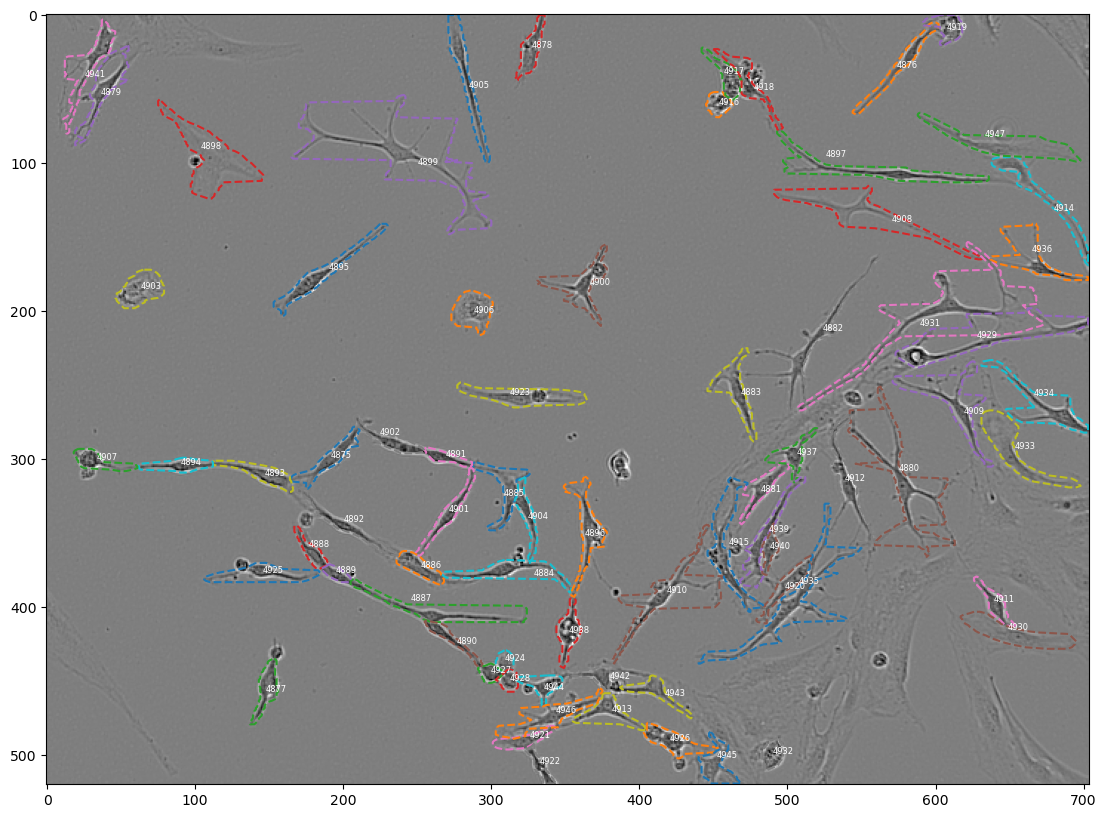

In [245]:
# selected_row_index = 300
# selected_row_id = df.loc[selected_row_index, 'id']
selected_row_id = '13325f865bb0'
selected_row_width = df.loc[selected_row_index, 'width']
selected_row_height = df.loc[selected_row_index, 'height']

new_df = df[df['id'] == selected_row_id]
image = plt.imread(f'{train_path}/{selected_row_id}.png')
plt.figure(figsize=(15, 10))
for index, row in tqdm(new_df.iterrows()):
    selected_row_annotation = row['annotation']

    mask = rle_decode(selected_row_annotation, (selected_row_height, selected_row_width))

    # Find the contour coordinates using numpy
    contours = get_contour(mask)
    contours_up = contours[::2]
    contours_down = contours[1::2]
    contours = np.concatenate((contours_up, contours_down[::-1]), axis=0)
    contours = np.concatenate((contours, contours[0].reshape(1, 2)), axis=0)


    cg_x = np.mean(contours[:, 1])
    cg_y = np.mean(contours[:, 0])

    plt.text(cg_x, cg_y, f'{index}', fontsize=6, color='white')
    plt.plot(contours[:, 1], contours[:, 0], '--')

plt.imshow(image, cmap=plt.cm.gray)
plt.show()

Now let's try the LIVECELL dataset, the A172 cell line

In [269]:
train_path = "./dataset/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/images/livecell_train_val_images/A172"
train_annotations = "./dataset/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/a172/livecell_a172_train.json"

with open(train_annotations, 'r') as file:
    # Read the JSON object from the file
    json_dict = json.load(file)

# Get all filenames in a list
filenames = [file['file_name'] for file in json_dict['images']]

annotations = json_dict['annotations']
first_key = list(annotations.keys())[0]
print(annotations[first_key])


{'segmentation': [[33.36, 295.33, 51.4, 284.51, 56.51, 280.0, 74.24, 260.77, 77.55, 256.56, 79.66, 254.75, 81.76, 253.85, 83.86, 253.85, 85.07, 256.56, 84.16, 260.77, 82.66, 264.07, 70.34, 279.7, 58.61, 293.53, 54.41, 299.84, 52.6, 302.25, 51.1, 304.05, 47.19, 305.25, 39.08, 307.36, 33.36, 307.66, 28.86, 307.66, 27.05, 307.66, 25.85, 307.06, 23.44, 305.56, 21.94, 303.75, 21.34, 301.95, 21.64, 298.94, 24.05, 297.14, 24.95, 297.14]], 'area': 902.5598000000173, 'iscrowd': 0, 'image_id': 195031, 'bbox': [21.34, 253.85, 63.72999999999999, 53.81000000000003], 'category_id': 1, 'id': 195032}
